# Comparação entre China e Itália Covid-19

In [7]:
# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import plotly.express as px

In [8]:
# importing datasets
full_table = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid.csv',parse_dates=['Date'],index_col=0)


In [9]:
# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values with NA
full_table[['Province/State']] = full_table[['Province/State']].fillna('NA')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



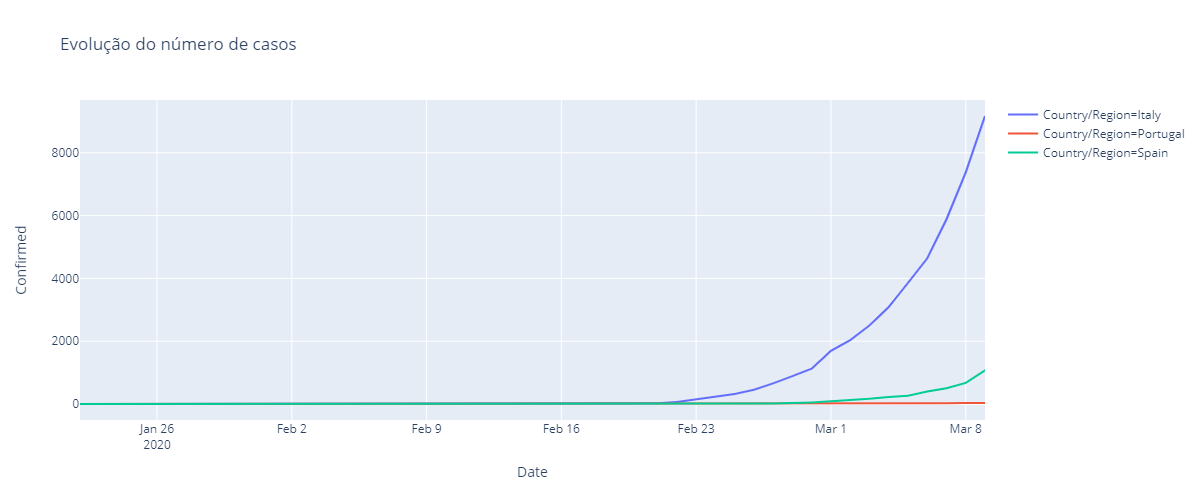

In [11]:
temp = full_table.loc[(full_table['Country/Region']=='Italy') | (full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()


fig = px.line(temp, x="Date", y="Confirmed", color='Country/Region',  height=500,width=1000,
             title='Evolução do número de casos')
fig.show()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



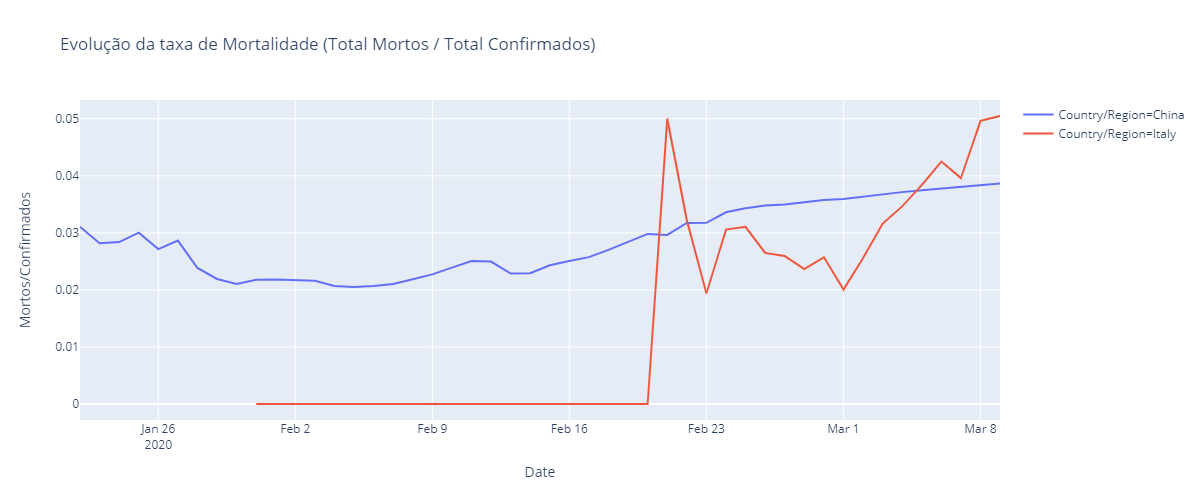

In [12]:
temp = full_table.loc[(full_table['Country/Region']=='Italy') | (full_table['Country/Region']=='China')]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()
temp['Mortos/Confirmados'] = temp['Deaths']/temp['Confirmed']


fig = px.line(temp, x="Date", y="Mortos/Confirmados", color='Country/Region',  height=500,width=1000,
             title='Evolução da taxa de Mortalidade (Total Mortos / Total Confirmados)')
fig.show()

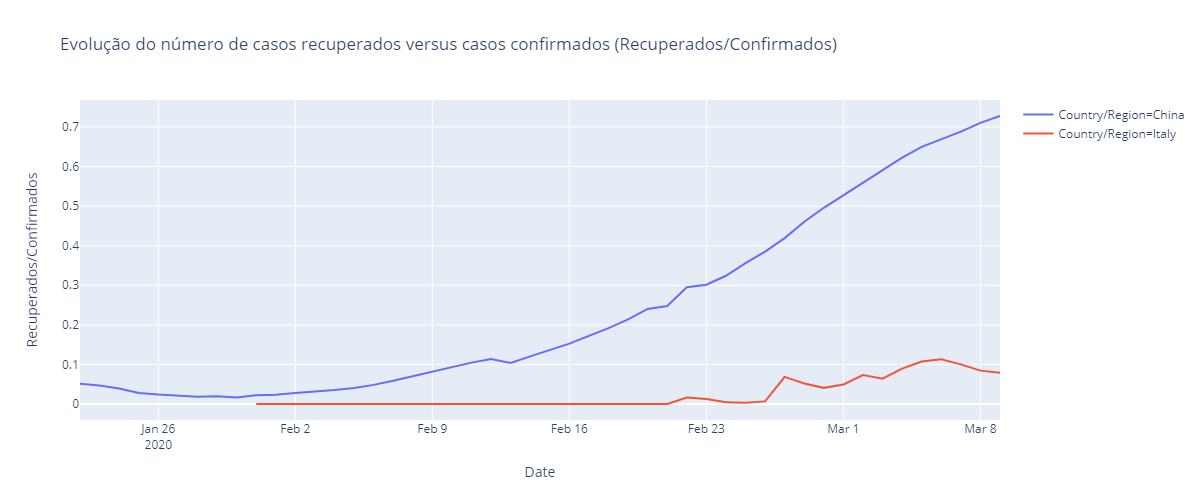

In [13]:
temp['Recuperados/Confirmados'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="Date", y="Recuperados/Confirmados", color='Country/Region',  height=500,width=1000,
             title='Evolução do número de casos recuperados versus casos confirmados (Recuperados/Confirmados)')
fig.show()

In [13]:
temp.loc[temp.Date == '2020-03-10']

,index,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered
12543,12543,NaN,France,47.0000,2.0000,2020-03-09,1209,19,12
12553,12553,NaN,Germany,51.0000,9.0000,2020-03-09,1176,2,18
12562,12562,NaN,Spain,40.0000,-4.0000,2020-03-09,1073,28,32
12565,12565,NaN,Belgium,50.8333,4.0000,2020-03-09,239,0,1
12593,12593,NaN,Greece,39.0742,21.8243,2020-03-09,73,0,0
12595,12595,NaN,Norway,60.4720,8.4689,2020-03-09,205,0,1
12619,12619,NaN,Portugal,39.3999,-8.2245,2020-03-09,30,0,0


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



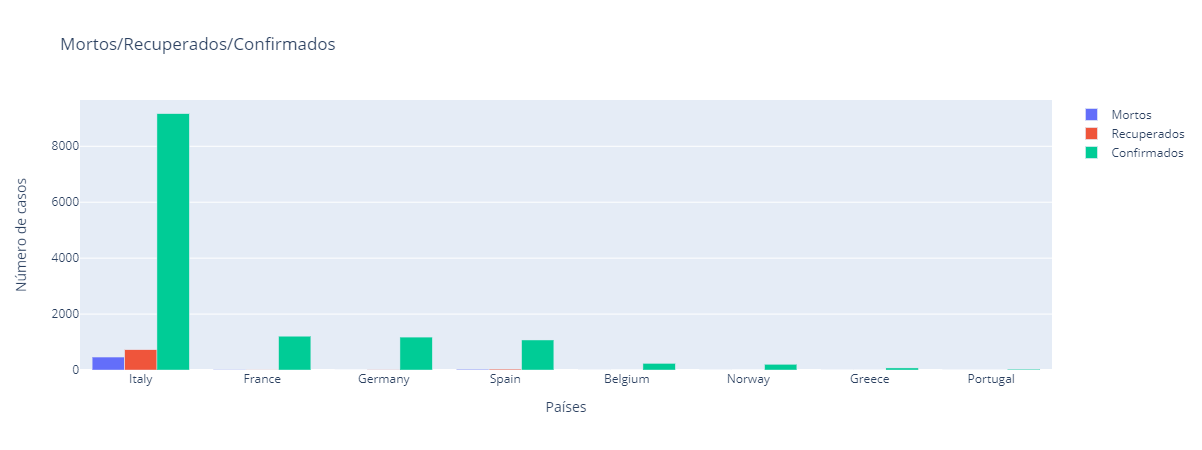

In [15]:
full_table = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid.csv',parse_dates=['Date'],index_col=0)
temp = full_table.loc[full_table.Date == '2020-03-09']
temp = temp.groupby(['Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().sort_values('Confirmed',ascending=False)


europa = ['Italy', 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']

temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]


import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
])

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)
fig.show()

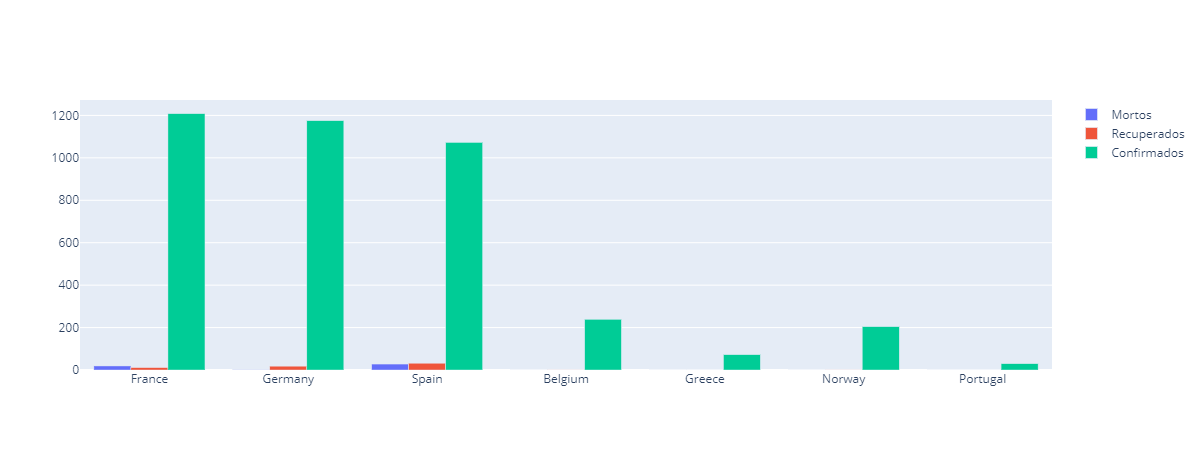

In [16]:
europa = [ 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']
temp=full_table.loc[full_table.Date == '2020-03-09']
temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]


fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
])

fig.show()

In [10]:
#temp['DeathsPercentagem'] = temp['Deaths'].cumsum()

#fig = px.line(temp, x="Date", y="Deaths",  color='Country/Region', height=500,width=1000,
#             title='Evolução Letalidade')
#fig.show()